### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET ='/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (384, 384)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'insurance'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None
NORM_STD =  None

BACKBONE = 'convnextv2_384'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 12
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [4]:
df.insurance.value_counts()

0.0    4719
1.0     396
Name: insurance, dtype: int64

In [5]:

df[LABEL] = df[LABEL].apply(lambda x: '0' if x == 0 else '1')

In [6]:
df[LABEL].value_counts()

0    4719
1     444
Name: insurance, dtype: int64

Train data shape: (4130, 25)
Test data shape: (1033, 25)


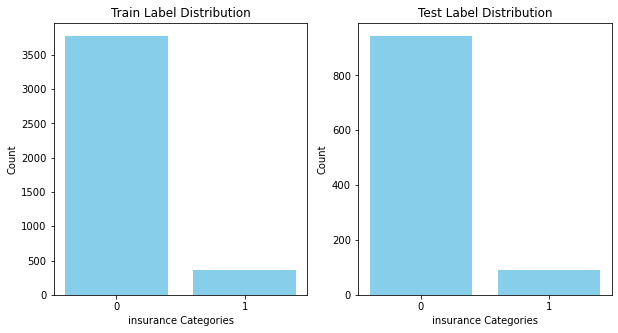

Getting validation set...


In [7]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
# df_test, df_val = split_data(df_test, LABEL, 0.20)
df_val=df_test

### Dataloaders

In [8]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [9]:
# Define the target image shape
  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((SHAPE)),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(25),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [10]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

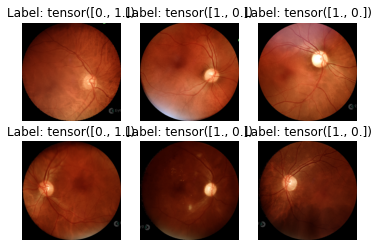

In [11]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [12]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
from transformers import ConvNextV2Model, ConvNextV2ForImageClassification,AutoModelForImageClassification
import torch

# Load the pre-trained ConvNeXt V2 model
model_name = "microsoft/swinv2-large-patch4-window12to24-192to384-22kto1k-ft"
model = AutoModelForImageClassification.from_pretrained(model_name)

# Modify the classifier head according to the new number of classes
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [13]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    print(class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [3775  355]


In [14]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 1, Train Loss: 0.028470350584636133, Val Loss: 0.0275723395933365, F1 Score: 0.07932263814616755, acc0.08615682478218781
cm[[  0 944]
 [  0  89]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 2, Train Loss: 0.02804554827997218, Val Loss: 0.027274711528557472, F1 Score: 0.47749114820435, acc0.9138431752178122
cm[[944   0]
 [ 89   0]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 3, Train Loss: 0.027954267537680225, Val Loss: 0.027279707635271138, F1 Score: 0.47749114820435, acc0.9138431752178122
cm[[944   0]
 [ 89   0]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 4, Train Loss: 0.02745390749549952, Val Loss: 0.02701952079332423, F1 Score: 0.08045159980931614, acc0.08712487899322362
cm[[  1 943]
 [  0  89]]


100%|██████████| 87/87 [00:24<00:00,  3.54it/s]


Epoch 5, Train Loss: 0.027424452235193356, Val Loss: 0.02693683575924443, F1 Score: 0.27832863288010834, acc0.29235237173281703
cm[[223 721]
 [ 10  79]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 6, Train Loss: 0.027413143050195515, Val Loss: 0.027092809735358447, F1 Score: 0.07932263814616755, acc0.08615682478218781
cm[[  0 944]
 [  0  89]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 7, Train Loss: 0.027238234548249106, Val Loss: 0.027104145119330663, F1 Score: 0.5205777425660884, acc0.904162633107454
cm[[929  15]
 [ 84   5]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 8, Train Loss: 0.02734918051763721, Val Loss: 0.026423150523640644, F1 Score: 0.5371587311069956, acc0.7676669893514037
cm[[761 183]
 [ 57  32]]


100%|██████████| 87/87 [00:24<00:00,  3.52it/s]


Epoch 9, Train Loss: 0.027284033421049084, Val Loss: 0.026752463830956096, F1 Score: 0.5226800154023874, acc0.9070667957405615
cm[[932  12]
 [ 84   5]]


100%|██████████| 87/87 [00:24<00:00,  3.52it/s]


Epoch 10, Train Loss: 0.026326610382808292, Val Loss: 0.027607732361460895, F1 Score: 0.5614672849046883, acc0.9002904162633107
cm[[919  25]
 [ 78  11]]


100%|██████████| 87/87 [00:24<00:00,  3.52it/s]


Epoch 11, Train Loss: 0.02654286247232686, Val Loss: 0.02545828830407954, F1 Score: 0.506865780177324, acc0.6466602129719264
cm[[609 335]
 [ 30  59]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 12, Train Loss: 0.025351161424718473, Val Loss: 0.025757182978264903, F1 Score: 0.46787516030448595, acc0.5827686350435625
cm[[541 403]
 [ 28  61]]


100%|██████████| 87/87 [00:24<00:00,  3.52it/s]


Epoch 13, Train Loss: 0.02449079986553693, Val Loss: 0.026950456260906898, F1 Score: 0.5611343047917252, acc0.7541142303969022
cm[[732 212]
 [ 42  47]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 14, Train Loss: 0.024744231194473696, Val Loss: 0.024426421343252576, F1 Score: 0.46749402973036475, acc0.5730880929332043
cm[[526 418]
 [ 23  66]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 15, Train Loss: 0.02191917599597271, Val Loss: 0.02435996275309516, F1 Score: 0.608546897500027, acc0.8305905130687319
cm[[818 126]
 [ 49  40]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 16, Train Loss: 0.020697629478746565, Val Loss: 0.026605853596809267, F1 Score: 0.5000937468328772, acc0.6302032913843175
cm[[589 355]
 [ 27  62]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 17, Train Loss: 0.01714427332744758, Val Loss: 0.025148044029871624, F1 Score: 0.6171019616788321, acc0.8238141335914811
cm[[805 139]
 [ 43  46]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 18, Train Loss: 0.016840210518516276, Val Loss: 0.023399597472757442, F1 Score: 0.6178181082544028, acc0.8034849951597289
cm[[775 169]
 [ 34  55]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 19, Train Loss: 0.01287522651862515, Val Loss: 0.031389989450924506, F1 Score: 0.6323874939973931, acc0.8393030009680542
cm[[821 123]
 [ 43  46]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 20, Train Loss: 0.01304027353366162, Val Loss: 0.03674592794823706, F1 Score: 0.6483408824545949, acc0.8731848983543078
cm[[864  80]
 [ 51  38]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 21, Train Loss: 0.01070067204207695, Val Loss: 0.037761463127925256, F1 Score: 0.6256511263136637, acc0.8731848983543078
cm[[871  73]
 [ 58  31]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 22, Train Loss: 0.010911494624915708, Val Loss: 0.02980466733014896, F1 Score: 0.6578834348618521, acc0.8499515972894482
cm[[826 118]
 [ 37  52]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 23, Train Loss: 0.009169769304993467, Val Loss: 0.023039112944388762, F1 Score: 0.6301713164315265, acc0.7909002904162633
cm[[749 195]
 [ 21  68]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 24, Train Loss: 0.007151990384875756, Val Loss: 0.03469531849861659, F1 Score: 0.7117320612455509, acc0.8973862536302033
cm[[878  66]
 [ 40  49]]


100%|██████████| 87/87 [00:24<00:00,  3.53it/s]


Epoch 25, Train Loss: 0.007034817101784806, Val Loss: 0.028639912868223698, F1 Score: 0.6893233082706767, acc0.8606001936108422
cm[[828 116]
 [ 28  61]]


100%|██████████| 87/87 [00:24<00:00,  3.52it/s]


Epoch 26, Train Loss: 0.006940720268049399, Val Loss: 0.033652630616792335, F1 Score: 0.7017692671274001, acc0.8906098741529526
cm[[871  73]
 [ 40  49]]


100%|██████████| 87/87 [00:24<00:00,  3.51it/s]


Epoch 27, Train Loss: 0.004652864513606629, Val Loss: 0.046875657577156636, F1 Score: 0.7610865537286942, acc0.9138431752178122
cm[[885  59]
 [ 30  59]]


100%|██████████| 87/87 [00:24<00:00,  3.52it/s]


Epoch 28, Train Loss: 0.006281395841358682, Val Loss: 0.03487247912696263, F1 Score: 0.7181358218147516, acc0.8983543078412392
cm[[877  67]
 [ 38  51]]


100%|██████████| 87/87 [00:24<00:00,  3.51it/s]


Epoch 29, Train Loss: 0.0051919780226497726, Val Loss: 0.03511165433707807, F1 Score: 0.6904477910112755, acc0.8518877057115198
cm[[813 131]
 [ 22  67]]


 89%|████████▉ | 307/345 [04:16<00:31,  1.20it/s]


KeyboardInterrupt: 

### Test

In [ ]:
test(model, test_dataloader, saliency=True, device=device)

In [ ]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

In [ ]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

In [ ]:
test(model, inadequate_dataloader, saliency=True, device=device)